In [1]:
#importing comet for commiting notebook work and model
from comet_ml import Experiment

In [2]:
# Setting the API key (saved as environment variable)
experiment = Experiment(api_key='f33Dock0REbyUn9mCQymBC3Vf', project_name="2201AC_ZF1", workspace="adegbem") 

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/adegbem/2201ac-zf1/13c25769e0284374b11e2c6f6b4e6bd1



Importing Libraries to be used in the notebook

In [3]:
# importing basic and fundamental libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

# libraries for NLP
from nltk.corpus import stopwords
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer

# importing libraries for utility from sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

# importing libraries for modelling form sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# libraries to check model metrics from sklearn
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Other modelling libraries
from xgboost import XGBClassifier

# Suppressing unnwarranted warnings
import warnings
warnings.filterwarnings("ignore")

# Loading Dataset

In [4]:
# Importing train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')

# displaying a few rows of both dataset
display(train_df.head())
display(test_df.head())


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Exploratory Data Analysis 

In [5]:
# getting an overview of the dataset; datatype, rows, null values and features in the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The dataset contains three features
- the dataset consist of `15819` rows
- there seems to be no null values


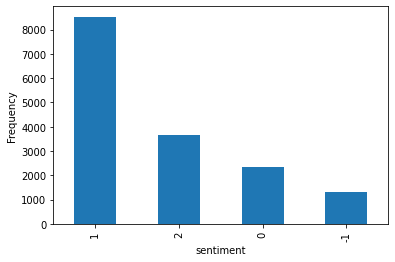

In [6]:
# plotting the distribution of the sentiment categories
train_df.sentiment.value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel('sentiment');

Most tweets support the man-made climate change which is represented by `1` while we have a fewer anti-climate change tweets

### Dealing with data imbalance 

dual-sampling:


,sentiment,message,tweetid
14203,1,RT @ChubbahBubbah: Trump Presidency promises 4...,55877
8855,-1,RT @JaredWyand: Steve Bannon means bye bye to ...,578512
309,0,@GeSemdicapt fuck global warming,101705
11331,-1,@Taniel @LVBurke The Russians did it - oh wait...,659577
1124,2,RT @ecojustice_ca: How cities are ahead of the...,787430


Class with there new resampled sizes
 1    4000
 2    4000
 0    4000
-1    4000
Name: sentiment, dtype: int64


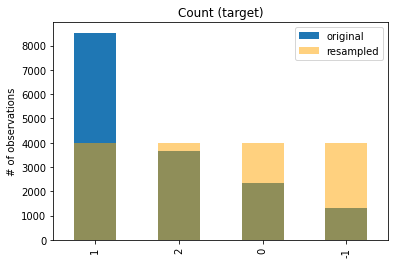

In [7]:
class_size = 4000 # setting an average or fixed size for each category in 'sentiment'
dd = train_df.sentiment.value_counts() # getting category name and their size
appended_data = [] # creating an empty list to append all category after resampling

# Creating a for-loop to resample and append to a list
for index, size in dd.items():
    if size < class_size: # setting condition to check if to downsampling or otherwise
        temp_pd = resample(train_df[train_df['sentiment']==index],
                          replace=True, # sample with replacement
                          n_samples=class_size, # match number in majority class
                          random_state=27)
    else:
        temp_pd = resample(train_df[train_df['sentiment']==index],
                          replace=False, # sample with replacement (no need to duplicate observations)
                          n_samples=class_size, # match number in minority class
                          random_state=27)
# Appending each category after resampling
    appended_data.append(temp_pd)

# Creating a new dataframe and viewing
df_train_sampled = pd.concat(appended_data, axis=0)
print('dual-sampling:')
display(df_train_sampled.sample(5))
print('Class with there new resampled sizes')
print(df_train_sampled.sentiment.value_counts())

# ploting the old and new graph frequency
ax = train_df.sentiment.value_counts().plot(kind='bar')
df_train_sampled.sentiment.value_counts().plot(kind='bar', title='Count (target)', 
                                               ax=ax,color='orange', alpha=0.5);
plt.xticks(range(len(dd)),dd.index)
plt.ylabel("# of observations")
plt.legend(['original','resampled'])
plt.show()

# Data Cleaning and Wrangling 

##### Creating a function to clean the `message`

In [8]:
# creating a function to clean the dataset
def cleaning(tweet):
# creating pattern to remove url link
    pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    rem_link = re.sub(pattern, '', tweet) # removing all links
    rem_punct = re.sub(r'[^a-zA-Z ]', '', rem_link) # removing all character apart from symbols
    rem_punct = re.sub(r'RT', '', rem_punct) # removing a specific word 'RT'
    word_split = rem_punct.lower().split() # coverting to lowercase and spliting 
    stops = set(stopwords.words("english")) # converting stopwords to 'set' for faster processing
    without_stop_sent = ' '.join([t for t in word_split if t not in stops]) # removing all stopwords from each tweet
    return without_stop_sent # returning the final cleaned tweet

# applying the function to 'message' in the dataset
train_df['cleaned_tweet'] = train_df.message.apply(cleaning)

In [9]:
# creating a function to stem each words
stemmer = SnowballStemmer('english')
# creating a function to lemmatize each words
lemmatizer = WordNetLemmatizer()

In [10]:
# creating new features using stemming
# creating a function that stem using 'stemmer' object earlier
def stemmer_fn(words, stemmer):
    word_split = set(words.split())
    return ' '.join([stemmer.stem(word) for word in word_split])

# applying the function to 'cleaned_tweet' in the dataset
train_df['stem_tweet'] = train_df.cleaned_tweet.apply(stemmer_fn, args=(stemmer, ))

In [11]:
# creating new features using stemming
# creating a function that lemmatize using 'lemmatizer' object created earlier
def lemmatizer_fn(words, lemmatizer):
    word_split = set(words.split())
    return ' '.join([lemmatizer.lemmatize(word) for word in word_split])

# applying the function to 'cleaned_tweet' in the dataset
train_df['lemma_tweet'] = train_df['cleaned_tweet'].apply(lemmatizer_fn, args=(lemmatizer, ))

In [12]:
# viewing the final dataframe with the cleaned, stemmed and lemmatized tweets
train_df.sample(10)

,sentiment,message,tweetid,cleaned_tweet,stem_tweet,lemma_tweet
4826,1,Will Paris deal tackle climate change? Some of...,860283,paris deal tackle climate change positive fact...,climat seen posit chang pari fact ive deal tac...,climate seen positive change paris fact ive de...
13564,2,China pledges to continue to be 'active player...,905578,china pledges continue active player climate c...,climat china chang continu pledg activ player ...,climate china change continue pledge active pl...
1106,0,New blog up about soil carbon sequestration as...,435763,new blog soil carbon sequestration climate cha...,sequestr vehicl climat restor chang ecolog soi...,sequestration vehicle climate restoration chan...
3610,1,RT @TheCCoalition: Have you seen 3 min trailer...,566454,theccoalition seen min trailer new sir david a...,min trailer climat seen sir david chang docume...,min trailer climate seen sir david change docu...
10981,1,RT @greenpeaceusa: 5 tips on how to talk clima...,433821,greenpeaceusa tips talk climate change family ...,climat tip season chang talk famili greenpeace...,climate tip season change talk family greenpea...
11167,1,RT @frankieboyle: Let's look on the bright sid...,402682,frankieboyle lets look bright side maybe clima...,start let climat global bright chang govern ki...,start let climate global bright change governm...
8368,2,@ScottAdamsSays Record-breaking climate change...,514246,scottadamssays recordbreaking climate change p...,push recordbreak scottadamssay climat unchart ...,push recordbreaking scottadamssays climate unc...
8172,0,If his warnings has been heard as with the eff...,916226,warnings heard effect global warming waste time,wast time heard effect global warm warn,waste time heard effect global warming warning
1083,2,Trump takes aim at Obama’s efforts to curb cli...,655645,trump takes aim obamas efforts curb climate ch...,climat take curb obama chang effort trump aim,climate take curb obamas change effort trump aim
9887,2,EPA administrator Scott Pruitt says he doubts ...,308538,epa administrator scott pruitt says doubts car...,emiss climat contribut chang doubt epa adminis...,emission climate contribute change doubt epa a...


## Engineering Features

In [13]:
# creating a sentiment_map
sentiment_dict = {'Anti-Climate':-1, 'Neutral':0, 'Pro-Climate':1, 'News-Fact':2}

In [14]:
# converting each word in the dataset into features
vectorizer = CountVectorizer(analyzer = "word", max_features = 8000) # setting the maximum feature to 8000 

In [15]:
# fitting the vectorizer object to the suitable column in the dataset
reviews_vect = vectorizer.fit_transform(train_df['cleaned_tweet'])

In [16]:
# converting the features to numpy array
train_data_features = reviews_vect.toarray() # for fast fitting of our dataset
train_data_features.shape # checking the shape to be sure of the size of the features

(15819, 8000)

In [17]:
# setting the target and features 
y = np.array(train_df['sentiment'])
X = train_data_features

# split the target ad features into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [18]:
# Creating a function to fit the model and calculate various metrics
def modelling(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_valid = model.predict(X_test)
    
# calculating the metrics
    f1_train = f1_score(y_train, pred_train, average='weighted')
    f1_test = f1_score(y_test, pred_valid,  average='weighted')
    cm = confusion_matrix(y_test, pred_valid)
    cr = classification_report(y_test, pred_valid, target_names=sentiment_dict, output_dict=True)
    
# creating a dataframe for 'confusion matrix' and 'classification report'
    cm_df = pd.DataFrame(cm, index = sentiment_dict, columns = sentiment_dict)
    cr_df = pd.DataFrame(cr)
    
    print('Confusion Matrix')
    display(cm_df)
    print('Classification Report')
    display(cr_df)
    print(f'Train accuracy(f1) is: {round(f1_train, 3)} and Validation accuracy(f1) is {round(f1_test, 3)}')
    
# Plotting the confusion matrix using heatmap
    plt.figure(figsize=(10,5))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    return cm_df, cr_df, cm # returning metrics

Confusion Matrix


,Anti-Climate,Neutral,Pro-Climate,News-Fact
Anti-Climate,124,33,99,23
Neutral,16,229,180,39
Pro-Climate,15,101,1441,134
News-Fact,6,27,160,537


Classification Report


,Anti-Climate,Neutral,Pro-Climate,News-Fact,accuracy,macro avg,weighted avg
precision,0.770186,0.587179,0.766489,0.732606,0.736726,0.714115,0.732702
recall,0.444444,0.493534,0.852158,0.735616,0.736726,0.631438,0.736726
f1-score,0.563636,0.536300,0.807057,0.734108,0.736726,0.660275,0.729055
support,279.000000,464.000000,1691.000000,730.000000,0.736726,3164.000000,3164.000000


Train accuracy(f1) is: 0.937 and Validation accuracy(f1) is 0.729


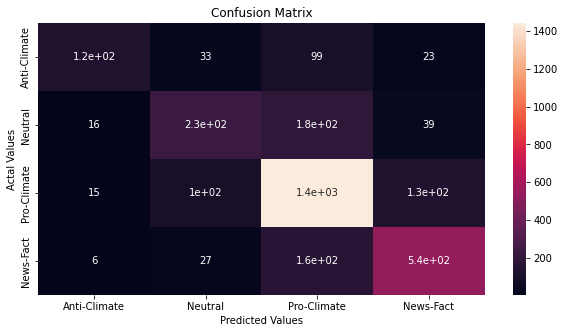

{'web': 'https://www.comet.ml/api/asset/download?assetId=3483ed7476aa4752bae0931565b078c9&experimentKey=13c25769e0284374b11e2c6f6b4e6bd1',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=3483ed7476aa4752bae0931565b078c9&experimentKey=13c25769e0284374b11e2c6f6b4e6bd1',
 'assetId': '3483ed7476aa4752bae0931565b078c9'}

In [19]:
# create logistic regression model instance
lm = LogisticRegression(C=2, solver='liblinear')

# fitting and predictiion by calling the 'modelling' fuction 
cm_df, cr_df, cm = modelling(lm)

# loging the confusion matric to comet
experiment.log_confusion_matrix(matrix=cm)

In [20]:
# Create dictionaries for the data we want to log

params = {"random_state": 10,
          "model_type": "lm"
          }
metrics = {"f1": cr_df.loc['f1-score', 'weighted avg'],
           "precision": cr_df.loc['precision', 'weighted avg'],
           "recall": cr_df.loc['recall', 'weighted avg']
           }

In [21]:
# Log our parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

#### Cleaning the test dataset

In [22]:
# applying the functions from earlier to clean our 'test' dataset
test_df['cleaned_tweet'] = test_df.message.apply(cleaning)
test_df['lemma_tweet'] = test_df['cleaned_tweet'].apply(lemmatizer_fn, args=(lemmatizer, ))
test_df['stem_tweet'] = test_df.cleaned_tweet.apply(stemmer_fn, args=(stemmer, ))

In [23]:
#  Double checking our dataframe was modified rightly
test_df.sample(5)

,message,tweetid,cleaned_tweet,lemma_tweet,stem_tweet
2421,RT @treubold: The connection between meat and ...,14362,treubold connection meat climate change great ...,connection climate explainer change civileats ...,connect climat explain chang civileat meat gre...
60,RT @CBSThisMorning: 'We now have a president i...,485211,cbsthismorning president america believe globa...,richardbranson believe cbsthismorning global a...,richardbranson believ cbsthismorn global ameri...
8407,RT @Isabellaak_: If you don't believe climate ...,20118,isabellaak dont believe climate change real yo...,tell leo climate real beforetheflood believe d...,tell leo climat real beforetheflood believ don...
5913,RT @AstroKatie: If you were going to be a sing...,41005,astrokatie going singleissue voter making glob...,global choose singleissue warming even would g...,global choos singleissu warm even would go mak...
5143,Obama fires scientist for being “too forthrigh...,209090,obama fires scientist forthright lawmakers reg...,obama lawmaker global forthright warming fire ...,obama lawmak global forthright warm fire regar...


In [24]:
# Converting the word of the all tweet into features using 'vectorizer' object created earlier
reviews_vect_test = vectorizer.transform(test_df['lemma_tweet'])

In [25]:
# converting into a numpy array
test_data_features = reviews_vect_test.toarray() # for fast fitting of our dataset
test_data_features.shape # checking to be sure is the same size with our 'train' dataset

(10546, 8000)

In [26]:
# Using the fitted (train) model to predict the 'test' dataset
pred_test = lm.predict(test_data_features)

In [27]:
# Saving test predictions to csv file
output = pd.DataFrame({'tweetid': test_df.tweetid,
                       'sentiment': pred_test})
output.to_csv('submission.csv', index=False)

In [28]:
# ending the comet logging 
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/adegbem/2201ac-zf1/13c25769e0284374b11e2c6f6b4e6bd1
COMET INFO:   Metrics:
COMET INFO:     f1        : 0.729054868131763
COMET INFO:     precision : 0.7327019478753439
COMET INFO:     recall    : 0.7367256637168141
COMET INFO:   Parameters:
COMET INFO:     C                 : 2
COMET INFO:     class_weight      : 1
COMET INFO:     dual              : False
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     l1_ratio          : 1
COMET INFO:     max_iter          : 100
COMET INFO:     model_type        : lm
COMET INFO:     multi_class       : auto
COMET INFO:     n_jobs            : 1
COMET INFO:     penalty           : l2
COMET INFO:     random_state      : 10
COMET INFO:     solver            : liblinear